In [1]:
import matplotlib as plt
import textwrap

In [2]:
import sys
sys.path.append('..')
from utils import *

In [3]:
# arxiv_number_list=['1106.6060','1812.04213','2004.04168','2008.08998','2012.04554','2108.02159','2110.11330','2111.01152','2112.07523',]
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]
# '2308.03843'

In [4]:
len(set(arxiv_number_list))

14

In [5]:
import pandas as pd

In [6]:
def load_arxiv(arxiv_number):
    # Load arxiv and convert to dict
    prompt_template='../prompt_template.md'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    # tasks = [f'Task:{idx+1} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    tasks = [kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    score_dict={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            assert isinstance(value, int), f'{arxiv_number}/{kwarg["task"]}:{key}:{value} is not int'
            if key not in score_dict:
                score_dict[key]=[value]
            else:
                score_dict[key].append(value)
    
    return pd.DataFrame(score_dict,index=tasks)

In [68]:
arxiv_dict_list={arxiv_number:load_arxiv(arxiv_number) for arxiv_number in arxiv_number_list}
execution=pd.concat(arxiv_dict_list.values(),keys=arxiv_dict_list.keys(),names=['arxiv_number','task'])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_file(score_dict):
    x = np.arange(len(score_dict['task']))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained',figsize=(8,5))
    color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]
    for attribute, measurement in score_dict['score'].items():
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xlabel('Score')
    ax.set_xticks([0,1,2])
    ax.set_title(f"{score_dict['arxiv']} [mean={np.mean(score_dict['score']['final answer accuracy']):.2f}]")
    ax.set_yticks(x + width*4, ['\n'.join(textwrap.wrap(task, width=40)) for task in score_dict['task']],fontsize=8)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

    ax.grid(axis='x',ls='--')
    # ax.set_ylim(0, 250)
    ax.set_xlim(-0.1,2.1)


In [9]:
for score_dict in score_dict_list:
    plot_single_file(score_dict)

NameError: name 'score_dict_list' is not defined

# Score by arxiv , compare with reading

In [10]:
execution_groupby_arxiv=execution.groupby('arxiv_number').agg(['mean','sem','count'])

In [11]:
execution_groupby_arxiv[['final answer accuracy']]

final_answer_accuracy                
                              mean       sem count
arxiv_number                                      
1010.1819                 1.333333  0.256235    12
1106.6060                 1.555556  0.175682     9
1208.0116                 1.727273  0.194978    11
1310.2674                 1.818182  0.121967    11
1812.04213                1.454545  0.207305    11
2004.04168                1.500000  0.223607     6
2008.08998                1.875000  0.125000     8
2012.04554                2.000000  0.000000     8
2108.02159                1.727273  0.194978    11
2110.11330                1.500000  0.267261     8
2111.01152                1.692308  0.133235    13
2112.07523                1.222222  0.277778     9
2308.03843                1.909091  0.090909    11
2308.07488                1.750000  0.130558    12

In [12]:
import pickle

In [13]:
with open('reading_data.pickle','rb') as f:
    reading_data=pickle.load(f)

In [14]:
reading_groupby_arxiv=reading_data.groupby('arxiv').agg(['mean','sem','count'])

In [15]:
reading_groupby_arxiv

Score                
                mean       sem count
arxiv                               
1010.1819   1.181034  0.080849   116
1106.6060   0.750000  0.134810    48
1208.0116   1.446429  0.080057   112
1310.2674   1.111111  0.090680    99
1812.04213  1.194915  0.087837   118
2004.04168  0.708333  0.109125    72
2008.08998  1.613636  0.083096    88
2012.04554  1.058140  0.101095    86
2108.02159  1.163934  0.085819   122
2110.11330  1.181818  0.099036    88
2111.01152  1.601190  0.054809   168
2112.07523  1.693878  0.068662    98
2308.03843  1.350000  0.088048   100
2308.07488  1.140845  0.080944   142

In [24]:
execution_reading=pd.concat([execution_groupby_arxiv[['final answer accuracy']],reading_groupby_arxiv],axis=1,).rename(columns={'final answer accuracy':'Execution','Score':'Extraction'})

In [25]:
execution_reading

Execution                 Extraction                
                mean       sem count       mean       sem count
1010.1819   1.333333  0.256235    12   1.181034  0.080849   116
1106.6060   1.555556  0.175682     9   0.750000  0.134810    48
1208.0116   1.727273  0.194978    11   1.446429  0.080057   112
1310.2674   1.818182  0.121967    11   1.111111  0.090680    99
1812.04213  1.454545  0.207305    11   1.194915  0.087837   118
2004.04168  1.500000  0.223607     6   0.708333  0.109125    72
2008.08998  1.875000  0.125000     8   1.613636  0.083096    88
2012.04554  2.000000  0.000000     8   1.058140  0.101095    86
2108.02159  1.727273  0.194978    11   1.163934  0.085819   122
2110.11330  1.500000  0.267261     8   1.181818  0.099036    88
2111.01152  1.692308  0.133235    13   1.601190  0.054809   168
2112.07523  1.222222  0.277778     9   1.693878  0.068662    98
2308.03843  1.909091  0.090909    11   1.350000  0.088048   100
2308.07488  1.750000  0.130558    12   1.140845  0.080944   142

In [29]:
execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]

0.011933818733358767

Text(0.5, 1.0, 'Correlation:0.0119')

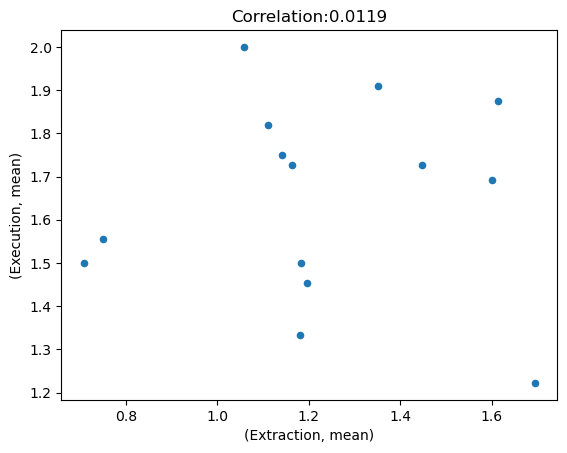

In [33]:
execution_reading.plot(kind='scatter',x=('Extraction','mean'),y=('Execution','mean'))
plt.title(f'Correlation:{execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]:0.04f}')

Text(0.5, 1.0, 'Mean of Execution: 1.23 $\\pm$ 0.09\nMean of Extraction: 1.65 $\\pm$ 0.17')

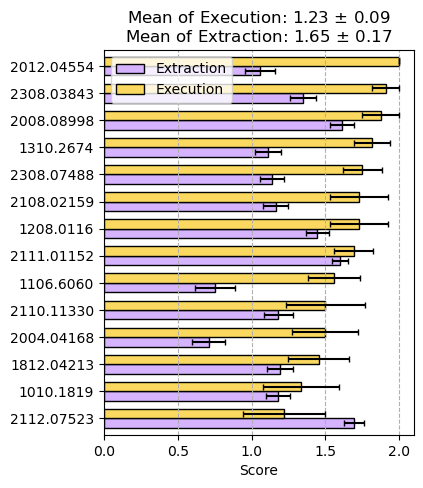

In [34]:
means = execution_reading.sort_values(by=('Execution','mean'))[[("Extraction", "mean"), ("Execution", "mean")]].droplevel(1,axis=1)
errors = execution_reading.sort_values(by=('Execution','mean'))[[("Extraction", "sem"), ("Execution", "sem")]].droplevel(1,axis=1)
ax = means.plot(kind='barh', xerr=errors, capsize=2,figsize=(4,5),color=['#d5b3ff','#fbd960'],edgecolor='k',width=0.7)
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
ax.set_title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Execution','Extraction'],means.mean(),errors.mean())]))


# Score by aspect

In [35]:
[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

[(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0),
 (0.03790849673202615, 0.32601307189542483, 0.6183006535947713, 1.0),
 (0.14666666666666667, 0.46039215686274504, 0.7186928104575163, 1.0),
 (0.2909803921568628, 0.5945098039215686, 0.7890196078431373, 1.0),
 (0.47294117647058825, 0.7116339869281045, 0.850718954248366, 1.0),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418, 1.0)]

In [69]:
execution.mean().iloc[2:]

follow_instructions      1.792857
physics_logic            1.814286
math_derivation          1.971429
final_answer_accuracy    1.650000
dtype: float64

In [70]:
new_col={key:key.replace(' ',' ') for key in execution.columns}

In [72]:
execution=execution.rename(columns=new_col)

Text(0.5, 1.0, 'Score of execution by different aspects of tasks')

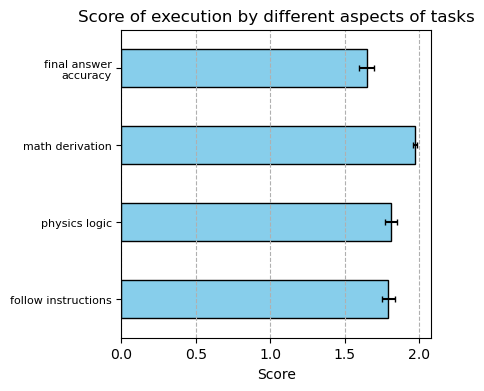

In [73]:
ax=execution.mean().iloc[2:].plot(kind='barh',xerr=execution.sem(),capsize=2,edgecolor='k',figsize=(4,4),color='skyblue')
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
ax.set_ylabel('')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution.mean().iloc[2:].index],fontsize=8)
ax.set_title('Score of execution by different aspects of tasks')

# Score by task

In [76]:
execution[(execution['final answer accuracy']==2) & (execution.iloc[:,2:-1].mean(axis=1)!=2)]

in paper  \
arxiv_number task                                                           
2012.04554   Construct Kinetic Hamiltonian (lattice version)            2   
             Convert noninteracting Hamiltonian in real spac...         0   
2110.11330   Convert noninteracting Hamiltonian in real spac...         0   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...         2   
2308.07488   Wick's theorem                                             0   

                                                                 prompt quality  \
arxiv_number task                                                                 
2012.04554   Construct Kinetic Hamiltonian (lattice version)                  2   
             Convert noninteracting Hamiltonian in real spac...               2   
2110.11330   Convert noninteracting Hamiltonian in real spac...               2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...               0   
2308.07488   Wick's theorem                                                   2   

                                                                 follow instructions  \
arxiv_number task                                                                      
2012.04554   Construct Kinetic Hamiltonian (lattice version)                       1   
             Convert noninteracting Hamiltonian in real spac...                    1   
2110.11330   Convert noninteracting Hamiltonian in real spac...                    1   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...                    1   
2308.07488   Wick's theorem                                                        1   

                                                                 physics logic  \
arxiv_number task                                                                
2012.04554   Construct Kinetic Hamiltonian (lattice version)                 2   
             Convert noninteracting Hamiltonian in real spac...              2   
2110.11330   Convert noninteracting Hamiltonian in real spac...              2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...              2   
2308.07488   Wick's theorem                                                  2   

                                                                 math derivation  \
arxiv_number task                                                                  
2012.04554   Construct Kinetic Hamiltonian (lattice version)                   2   
             Convert noninteracting Hamiltonian in real spac...                2   
2110.11330   Convert noninteracting Hamiltonian in real spac...                2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...                2   
2308.07488   Wick's theorem                                                    2   

                                                                 final answer accuracy  
arxiv_number task                                                                       
2012.04554   Construct Kinetic Hamiltonian (lattice version)                         2  
             Convert noninteracting Hamiltonian in real spac...                      2  
2110.11330   Convert noninteracting Hamiltonian in real spac...                      2  
2112.07523   Reduce momentum in Hartree term (momentum in BZ...                      2  
2308.07488   Wick's theorem                                                          2

In [77]:
execution_groupby_task=execution.groupby('task').agg(['mean','sem','count'])

In [78]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [161]:
# naming_order=[for key in (naming.keys()) if key in execution_groupby_task]

In [82]:
execution_groupby_task_mean=execution_groupby_task[execution_groupby_task[('in paper','count')]>2].sort_values(by=('final answer accuracy','mean')).loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
execution_groupby_task_sem=execution_groupby_task[execution_groupby_task[('in paper','count')]>2].sort_values(by=('final answer accuracy','mean')).loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)

Text(0.5, 1.0, 'Score of execution by tasks')

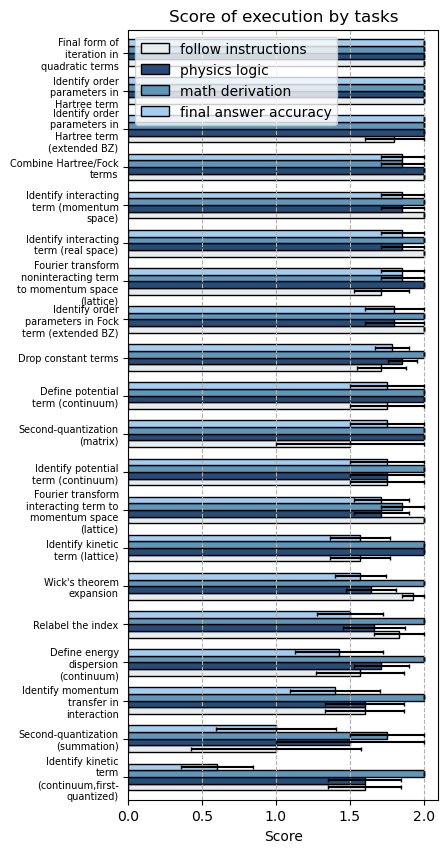

In [168]:
ax=execution_groupby_task_mean.plot(kind='barh',xerr=execution_groupby_task_sem,figsize=(4,10),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=20)) for task in execution_groupby_task_mean.index],fontsize=7)
ax.set_title('Score of execution by tasks')

# Score by task type

In [99]:
with open('../Task_type.yaml','r') as f:
    task_type=yaml.safe_load(f)

In [100]:
task_type_order=['Hamiltonian of QMB problem','Hamiltonian in momentum space','Mean field decomposition','Hartree and Fock terms','Order parameter']

In [101]:
execution.index=pd.MultiIndex.from_tuples([(index[0],task_type[index[1]],index[1]) for index in execution.index.tolist()],names=['arxiv_number','task_type','task'])

In [103]:
execution_groupby_task_type=execution.groupby('task_type').agg(['mean','sem','count'])
# data_groupby_task=data_groupby_task.loc[task_type_order[::-1]]

Text(0.5, 1.0, 'Score of execution by different steps')

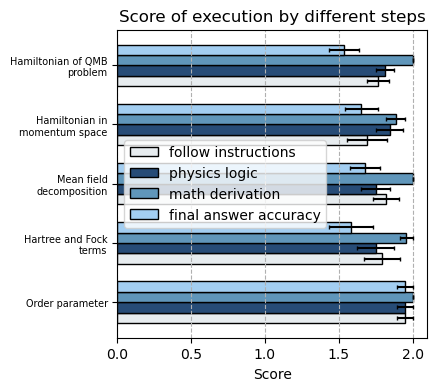

In [106]:
execution_groupby_task_type_mean=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
execution_groupby_task_type_sem=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)
ax=execution_groupby_task_type_mean.plot(kind='barh',xerr=execution_groupby_task_type_sem,figsize=(4,4),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_task_type_mean.index],fontsize=7)
ax.set_title('Score of execution by different steps')

# Score by branch

In [107]:
branch_from_arxiv=dict(zip(reading_data.index.get_level_values(1),reading_data.index.get_level_values(0)))

In [108]:
branch_from_arxiv

{'1010.1819': 'continuum, first-quantized',
 '1208.0116': 'continuum, first-quantized',
 '2111.01152': 'continuum, first-quantized',
 '2308.07488': 'continuum, first-quantized',
 '2108.02159': 'continuum, second-quantized',
 '2112.07523': 'continuum, second-quantized',
 '1106.6060': 'lattice, second-quantized',
 '1310.2674': 'lattice, second-quantized',
 '1812.04213': 'lattice, second-quantized',
 '2004.04168': 'lattice, second-quantized',
 '2008.08998': 'lattice, second-quantized',
 '2012.04554': 'lattice, second-quantized',
 '2110.11330': 'lattice, second-quantized',
 '2308.03843': 'lattice, second-quantized'}

In [109]:
[(branch_from_arxiv[index[0]],)+index for index in execution.index.tolist()]

[('continuum, first-quantized',
  '1010.1819',
  'Hamiltonian of QMB problem',
  'Construct Kinetic Hamiltonian (continuum version, single-particle)'),
 ('continuum, first-quantized',
  '1010.1819',
  'Hamiltonian of QMB problem',
  'Define each term in Kinetic Hamiltonian (continuum version)'),
 ('continuum, first-quantized',
  '1010.1819',
  'Hamiltonian in momentum space',
  'Convert from single-particle to second-quantized form, return in matrix'),
 ('continuum, first-quantized',
  '1010.1819',
  'Hamiltonian in momentum space',
  'Convert from single-particle to second-quantized form, return in summation (expand the matrix)'),
 ('continuum, first-quantized',
  '1010.1819',
  'Hamiltonian of QMB problem',
  'Construct interaction Hamiltonian (momentum space)'),
 ('continuum, first-quantized',
  '1010.1819',
  'Mean field decomposition',
  "Wick's theorem"),
 ('continuum, first-quantized',
  '1010.1819',
  'Mean field decomposition',
  'Extract quadratic term'),
 ('continuum, first-

In [110]:
execution.index=pd.MultiIndex.from_tuples([(branch_from_arxiv[index[0]],)+index for index in execution.index.tolist()],names=['branch','arxiv_number','task_type','task'])

In [111]:
execution_groupby_branch=execution.groupby('branch').agg(['mean','sem','count'])

Text(0.5, 1.0, 'Score of execution by branches')

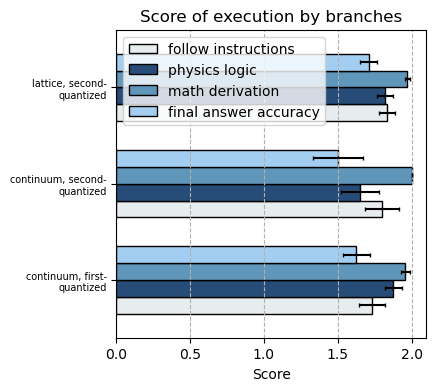

In [116]:
execution_groupby_branch_mean=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
exeution_groupby_branch_sem=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)
ax=execution_groupby_branch_mean.plot(kind='barh',xerr=exeution_groupby_branch_sem,figsize=(4,4),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_branch_mean.index],fontsize=7)
ax.set_title('Score of execution by branches')

# Score conditioned on in paper

In [117]:
execution_groupby_in_paper=execution.groupby('in paper').agg(['mean','sem','count'])

In [118]:
execution_groupby_in_paper

prompt quality                 follow instructions                  \
                   mean       sem count                mean       sem count   
in paper                                                                      
0              1.962963  0.025941    54            1.722222  0.085319    54   
1              1.825000  0.060843    40            1.850000  0.067463    40   
2              1.739130  0.078849    46            1.826087  0.064489    46   

         physics logic                 math derivation                  \
                  mean       sem count            mean       sem count   
in paper                                                                 
0             1.777778  0.073195    54        2.000000  0.000000    54   
1             1.850000  0.067463    40        1.925000  0.042176    40   
2             1.826087  0.056503    46        1.978261  0.021739    46   

         final answer accuracy                  
                          mean       sem count  
in paper                                        
0                     1.666667  0.083595    54  
1                     1.700000  0.081650    40  
2                     1.586957  0.096189    46

Text(0.5, 1.0, 'Overlap between asnwers and training papers')

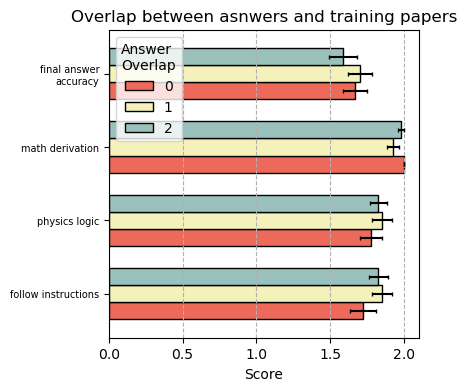

In [142]:
execution_groupby_in_place_mean=execution_groupby_in_paper[execution_groupby_in_paper[('final answer accuracy','count')]>2].loc[:,(slice(None),'mean')].iloc[:,-4:].droplevel(1,axis=1).T
execution_groupby_in_place_sem=execution_groupby_in_paper[execution_groupby_in_paper[('final answer accuracy','count')]>2].loc[:,(slice(None),'sem')].iloc[:,-4:].droplevel(1,axis=1).T
ax=execution_groupby_in_place_mean.plot(kind='barh',xerr=execution_groupby_in_place_sem,figsize=(4,4),color=['#ed6a5a','#f4f1bb','#9bc1bc'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_in_place_mean.index],fontsize=7)
ax.legend().set_title('Answer\nOverlap')
ax.set_title('Overlap between asnwers and training papers')

In [127]:
execution_groupby_branch_mean

,follow instructions,physics logic,math derivation,final answer accuracy
branch,,,,
"continuum, first-quantized",1.729167,1.875000,1.958333,1.625000
"continuum, second-quantized",1.800000,1.650000,2.000000,1.500000
"lattice, second-quantized",1.833333,1.819444,1.972222,1.708333


# Score conditioned on prompt_quality

In [130]:
execution_groupby_prompt_quality=execution.groupby('prompt quality').agg(['mean','sem','count'])

In [131]:
execution_groupby_prompt_quality

in paper                 follow instructions                  \
                    mean       sem count                mean       sem count   
prompt quality                                                                 
0               2.000000  0.000000     2            1.500000  0.500000     2   
1               1.352941  0.170233    17            1.764706  0.136377    17   
2               0.867769  0.076908   121            1.801653  0.046384   121   

               physics logic                 math derivation                  \
                        mean       sem count            mean       sem count   
prompt quality                                                                 
0                   1.500000  0.500000     2        2.000000  0.000000     2   
1                   1.588235  0.123038    17        2.000000  0.000000    17   
2                   1.851240  0.040078   121        1.966942  0.016321   121   

               final answer accuracy                  
                                mean       sem count  
prompt quality                                        
0                           1.000000  1.000000     2  
1                           1.235294  0.182495    17  
2                           1.719008  0.048707   121

prompt quality
0      2
1     17
2    121
Name: (in paper, count), dtype: int64

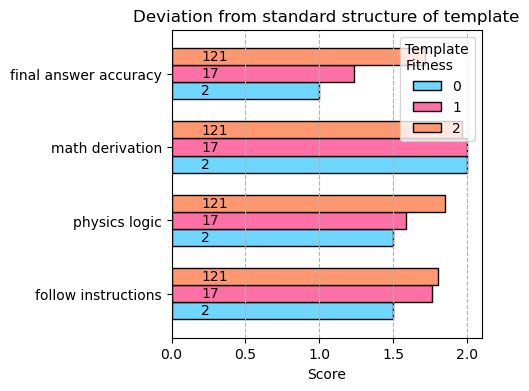

In [165]:
execution_groupby_prompt_quality_mean=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('final answer accuracy','count')]>=2].loc[:,(slice(None),'mean')].iloc[:,-4:].droplevel(1,axis=1).T
execution_groupby_prompt_quality_sem=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('final answer accuracy','count')]>=2].loc[:,(slice(None),'sem')].iloc[:,-4:].droplevel(1,axis=1).T
ax=execution_groupby_prompt_quality_mean.plot(kind='barh',figsize=(4,4),color=['#70d6ff','#ff70a6','#ff9770','#ffd670'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_prompt_quality_mean.index],fontsize=7)
ax.set_yticks(np.arange(4))
ax.legend().set_title('Template\nFitness')
ax.set_title('Deviation from standard structure of template')

for index,value in enumerate(execution_groupby_prompt_quality[('in paper','count')]):
# for yval,(xval,val) in enumerate(zip(execution_groupby_prompt_quality[('in paper','count')],))
    for idx in range(4):
        ax.text(0.2, idx+(index-1)*0.7/3, str(value), color='black', va='center')

In [ ]:
execution_groupby_branch_mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
in_paper,,,,
0,1.722222,1.777778,2.000000,1.666667
1,1.850000,1.850000,1.925000,1.700000
2,1.826087,1.826087,1.978261,1.586957


In [269]:
execution_groupby_task_mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
task_type,,,,
Hamiltonian of QMB problem,1.767442,1.813953,2.000000,1.534884
Hartree and Fock terms,1.791667,1.750000,1.958333,1.583333
Hamiltonian in momentum space,1.692308,1.846154,1.884615,1.653846
Mean field decomposition,1.821429,1.750000,2.000000,1.678571
Order parameter,1.947368,1.947368,2.000000,1.947368


Text(0.5, 0, 'Score')

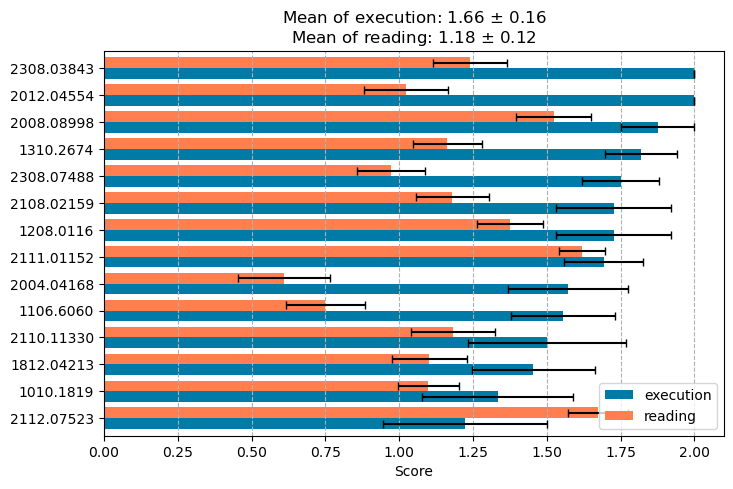

In [ ]:
execution_reading_mean=pd.concat([arxiv_dict_mean,reading_data_mean],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')
execution_reading_se=pd.concat([arxiv_dict_se,reading_data_se],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')

execution_reading_mean.plot(kind='barh',color=['#007BA7', '#FF7F50'],figsize=(8,5),width=0.8,xerr=execution_reading_se,capsize=3)
plt.title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Execution','Extraction'],execution_reading_mean.mean(),execution_reading_se.mean())]))
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

Text(0.5, 0, 'Score')

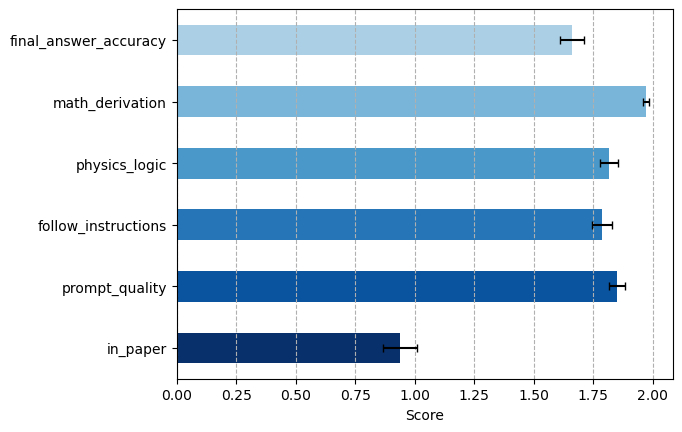

In [ ]:
arxiv_dict.mean().plot(kind='barh',color=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)],xerr=arxiv_dict.sem(),capsize=3,)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
import pandas as pd

In [ ]:
def load_score(arxiv_number):
    prompt_template='../prompt_template.md'
    # arxiv_number='1106.6060'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks=[f'Task:{idx} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    aspect_score={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            if key not in aspect_score:
                aspect_score[key]=[value]
            else:
                aspect_score[key].append(value)
    return pd.DataFrame(aspect_score,index=tasks)

In [ ]:
df_list=[load_score(arxiv_number) for arxiv_number in arxiv_number_list]

In [ ]:
dfs=pd.concat(df_list,keys=arxiv_number_list,names=['arxiv_number','task'])

In [ ]:
dfs

NameError: name 'dfs' is not defined

Text(0.5, 0, 'Score')

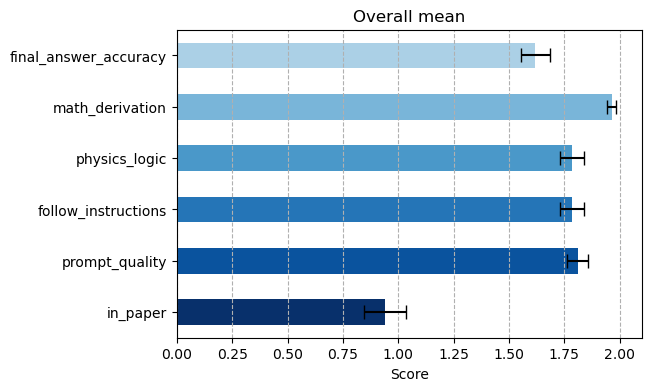

In [ ]:
error_bar=dfs.std().values/dfs.shape[0]**0.5
dfs.mean().plot(kind='barh',figsize=(6,4),xlim=(0,2.1),title='Overall mean',color=color_list,xerr=error_bar,capsize=5)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
df.T

,Original Score,Conditional Score
Quality,8,7
Efficiency,6,5
Reliability,7,8
Innovation,9,8


In [ ]:
group='in_paper'
# group='prompt_quality'
mean=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].mean()
error_bar=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].std()/arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].count()**0.5


In [ ]:
mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
in_paper,,,,
0,1.727273,1.781818,2.000000,1.672727
1,1.850000,1.850000,1.925000,1.725000
2,1.804348,1.826087,1.978261,1.586957


In [ ]:
list(mean.iterrows())

[(0,
  follow_instructions      1.727273
  physics_logic            1.781818
  math_derivation          2.000000
  final_answer_accuracy    1.672727
  Name: 0, dtype: float64),
 (1,
  follow_instructions      1.850
  physics_logic            1.850
  math_derivation          1.925
  final_answer_accuracy    1.725
  Name: 1, dtype: float64),
 (2,
  follow_instructions      1.804348
  physics_logic            1.826087
  math_derivation          1.978261
  final_answer_accuracy    1.586957
  Name: 2, dtype: float64)]

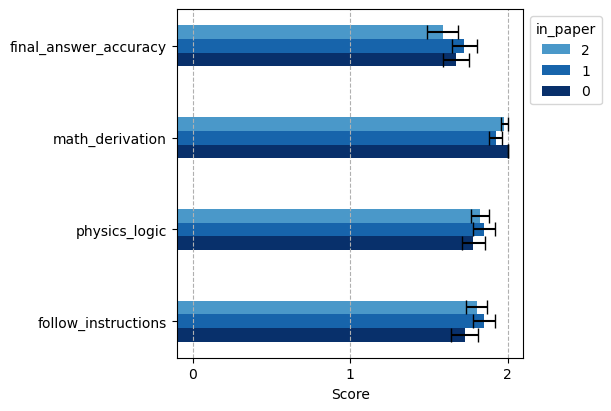

In [ ]:
x = np.arange(mean.shape[1])  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))
color_list=[plt.cm.Blues(0.2+0.8*(i/4)) for i in range(4,0,-1)]
# for attribute, measurement in aspect_score.items():
for attribute, measurement in mean.iterrows():
    offset = width * multiplier
    if not error_bar.loc[attribute].isna().any():
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1,xerr=error_bar.loc[attribute].values,capsize=5)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
# ax.set_title(f"{arxiv_number}")
ax.set_yticks(x + width*1, ['\n'.join(textwrap.wrap(label, width=40)) for label in mean.columns])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1),title=group)

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()